In [1]:
import torch
from torchvision.datasets import mnist
import numpy as np
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class MushroomDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        df_train = pd.read_csv(self.file_path)
        self.labels = np.array(df_train['class'])
        self.dataset =  np.array(df_train.drop('class', axis=1))
    def __getitem__(self, index):
        """
        return a single data and a corresponding single label
        """
        return self.dataset[index], self.labels[index]

    def __len__(self):
        """
        return total data length
        """
        return len(self.dataset)
trainset = MushroomDataset('./mushroom_train.csv')
testset = MushroomDataset('./mushroom_test.csv')

train_data = DataLoader(trainset, batch_size=32, shuffle=True)
test_data = DataLoader(testset, batch_size=64, shuffle=False)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(98, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# build model
model = DNN().to(device)

# define cost
criterion = nn.CrossEntropyLoss()

# optimization
optimizer = torch.optim.SGD(model.parameters(), 0.1)
#optimizer = torch.optim.RMSprop(model.parameters(), 0.01, alpha=0.9)
#optimizer = torch.optim.Adam(model.parameters(), 0.01, betas=(0.9, 0.99))

losses = []
acces = []
eval_losses = []
eval_acces = []



for epoch in range(5):
    train_loss = 0
    train_acc = 0
    model.train()      
    
    for im, label in train_data:
        
        im = im.to(device)
        label = label.to(device)
        pred = model(im.float())
        
        loss = criterion(pred, label)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        

        _, pred = pred.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    

    eval_loss = 0
    eval_acc = 0
    model.eval()
    
    for im, label in test_data:

        im = im.to(device)
        label = label.to(device)
        
        pred = model(im.float())
        loss = criterion(pred, label)

        
        eval_loss += loss.item()

        
        _, pred = pred.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(epoch, train_loss / len(train_data), train_acc / len(train_data), eval_loss / len(test_data), eval_acc / len(test_data)))

Using cpu device
epoch: 0, Train Loss: 0.217739, Train Acc: 0.899884, Eval Loss: 0.025038, Eval Acc: 0.996528
epoch: 1, Train Loss: 0.012904, Train Acc: 0.998821, Eval Loss: 0.006509, Eval Acc: 1.000000
epoch: 2, Train Loss: 0.004637, Train Acc: 0.999803, Eval Loss: 0.003082, Eval Acc: 1.000000
epoch: 3, Train Loss: 0.002456, Train Acc: 1.000000, Eval Loss: 0.001780, Eval Acc: 1.000000
epoch: 4, Train Loss: 0.001604, Train Acc: 1.000000, Eval Loss: 0.001242, Eval Acc: 1.000000


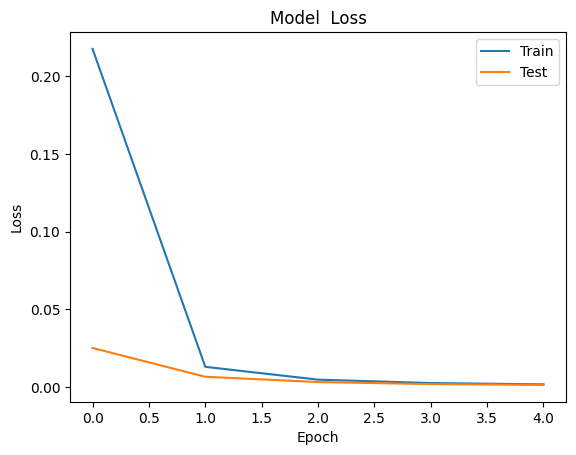

In [2]:
plt.plot(np.arange(0,5),losses)
plt.plot(np.arange(0,5),eval_losses)
plt.title('Model  Loss')
plt.xlabel('Epoch')        
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

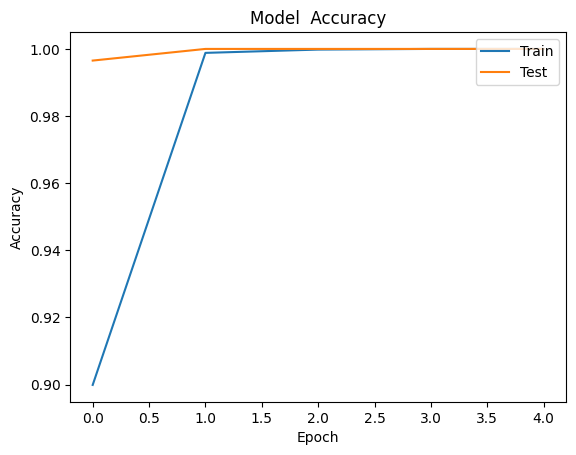

In [3]:
plt.plot(np.arange(0,5),acces)
plt.plot(np.arange(0,5),eval_acces)
plt.title('Model  Accuracy')
plt.xlabel('Epoch')        
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()